### Import libraries

In [139]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import t

import time
import pandas as pd
from gym import spaces
import numpy as np
import os
import gym
import warnings

from simply.actor import Actor, Order
from simply.battery import Battery
from simply.market_fair import BestMarket, MARKET_MAKER_THRESHOLD
from simply.power_network import PowerNetwork

import networkx as nx
import datetime
import random
import signal


## SimplyGym Environment

### Helper Functions:

In [36]:
class TimeoutException(Exception):  
    pass

def timeout_handler(signum, frame):
    raise TimeoutException()

In [20]:
def create_random_dataframe(horizon, max_load=3, max_pv=1.3, max_price=0.8):
    """
    Creates a random dataframe with 24 hours of data
    """
    # Create a random array and update it into a DataFrame
    load = np.round(np.random.uniform(0, max_load, horizon).astype('float16'), 3)
    pv = np.round(np.random.uniform(0, max_pv, horizon).astype('float16'), 3)
    prices = np.round(np.random.uniform(0.001, max_price, horizon).astype('float16'), 3)
    
    df = pd.DataFrame({
        'load': load,
        'pv': pv,
        'prices': prices,
        'schedule': (load - pv),
    })
    
    return df

In [21]:
def generate_aggregated_actor_df(horizon=24, index=None, df=None, path='/Users/emilmargrain/Documents/RLI/sample/aggregated_df.csv'):
    if df is None:
        df = pd.read_csv(path).round(3)
        # df = df.copy()
    # df['index'] = df.index
    # df['index'] = df['index'].astype(int)
    if index is None:
        index = random.randrange(0, len(df) - horizon)
    df = df.iloc[index:horizon+index]

    # limit the values to fit the observation space
    df.loc[:, 'load'] = df['load'].clip(0, 1.399)
    df.loc[:, 'pv'] = df['pv'].clip(0, 1.399)
    df.loc[:, 'prices'] = df['prices'].clip(0, 1)

    df.loc[:, 'schedule'] = df['load'] - df['pv']
    return df

### Environment:

In [22]:
def start_training(algorithm_name, initial_soc=None, horizon=96, pretrained_model=None, restart=False, version=0, energy_unit=0.001, stored_value=0.7, aggregated=False, random=False, max_obv=0.8):
        # Set up training variables
    time_now = datetime.datetime.now()
    time_now = time_now.strftime("%m-%d-%H-%M")

    algorithm_name = f'{algorithm_name}_{time_now}'
    TIMESTEPS = 10000
    models_dir = f"models/{algorithm_name}"
    logdir = "logs"

    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    # Create environment

    env = MyEnv(horizon=horizon, initial_soc=initial_soc, energy_unit=energy_unit, stored_value=stored_value, aggregated=aggregated, random=random, max_obv=max_obv)

    # Restart training from a previous model
    if pretrained_model:
        models_dir = f"models/{algorithm_name}"
        pretrained_model_path = f"models/{pretrained_model}/{str(version)}"
        # algorithm_name = pretrained_model
        model = PPO.load(pretrained_model_path, reset_num_timesteps=restart, tensorboard_log=logdir, verbose=1, env=env)
    else:
            model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=logdir, device='cpu')
    try:
        # Train the agent
        for i in range(1, 100000):
            print(i)
            model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=restart, tb_log_name=f'{algorithm_name}')
            if i % 2 == 0:
                model.save(f"{models_dir}/{TIMESTEPS*i+version}")
            
    except Exception as e:
        print(f'Error: {e}')
        env = model.get_env()
        env.render()

    return algorithm_name, model


In [23]:
class MyEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, horizon=24, initial_soc=None, energy_unit=0.001, stored_value=0.7, actor_df=None, aggregated=True, random=False, max_obv=0.8):
        super(MyEnv, self).__init__()

        self.aggregated = aggregated
        self.random = random
        self.actor_df = actor_df
        self.max_obv = max_obv
        self._setup(horizon, initial_soc, energy_unit, stored_value, actor_df)

        # Create action space
        self.action_energy_values = np.arange(-max_obv, max_obv, self.m.energy_unit)
        self.action_price_values = np.arange(0.001, 0.6, self.m.energy_unit)
        self.action_space = gym.spaces.MultiDiscrete([len(self.action_energy_values), len(self.action_price_values)])

        # Create observation space
        self.observation_values = np.arange(0, max_obv, self.m.energy_unit)
        self.observation_bins = [len(self.observation_values) for _ in range(self.horizon * 3 + 1)]
        self.observation_space = gym.spaces.MultiDiscrete(self.observation_bins)    
        
    def _setup(self, horizon, inital_soc, energy_unit, stored_value, actor_df=None):

        # How many timesteps to observe when training
        self.horizon = horizon
        
        # Size of energy unit
        self.energy_unit = energy_unit
        self.stored_value = stored_value

        # Initial soc of battery (should be random when training)
        if inital_soc is None:
            self.inital_soc = round(np.random.random(), 3)
        else:
            self.inital_soc = inital_soc

        # Training related elements
        if self.actor_df is not None:
            self.actor_df = self.actor_df
        elif self.aggregated:
            if self.random:
                self.actor_df = create_random_dataframe(horizon=self.horizon*2, max_load=0.5, max_pv=0.8, max_price=0.6)
            else:
                df = pd.read_csv('/Users/emilmargrain/Documents/GitHub/simply/total_aggregated.csv')
                self.actor_df = generate_aggregated_actor_df(index=0, horizon=self.horizon*2, df=df)
        else:
            self.actor_df = generate_actor_df(self.horizon*2)

        self.m = BestMarket(0, grid_fee_matrix=[[0]])
        self.m.energy_unit = energy_unit
        battery = Battery(soc_initial=self.inital_soc)
        self.actor = Actor('RL', self.actor_df, battery=battery, horizon=self.horizon, ps=1)
        
        self.current_timestep_prediction = self.actor.pred[['load', 'pv', 'prices']].values
        
    def _convert_observation(self, observation):
        """Convert observation to discrete values"""
        # observation = np.digitize(observation, bins=self.observation_values)
        observation = np.multiply(observation, 1000)
        observation = observation.astype(int)
        return observation

    def _add_soc_to_obs(self, observation):
        """Add soc to observation"""
        observation = np.append(observation, self.actor.battery.soc)
        return observation
    
    def _flatten_obs(self, observation):
        """Flatten observation"""
        return observation.flatten()

    def _next_observation(self):
        """Return observation"""
        # replace missing values with 0
        # observation = np.nan_to_num(observation, nan=0)
        self.actor.create_prediction()
        # Add predicted load, pv and prices to observation
        observation = self.actor.pred[['load', 'pv', 'prices']].values

        # Flatten observation
        observation = self._flatten_obs(observation)

        # Add battery soc
        observation = self._add_soc_to_obs(observation)

        # Convert observation to discrete values
        # TODO: Make sure this is rounding correctly
        observation = self._convert_observation(observation)

        # TODO: Add aggregated data from other market actors

        return observation

    def _handle_market(self, order):
        """Add market maker, clear market and progress timestep."""
        # Add RL order
        self.m.accept_order(order)

        # Add market maker orders
        mm_bid = Order(-1, self.actor.t, 'market_maker', None,
                         MARKET_MAKER_THRESHOLD,
                         self.actor.pred['prices'][0])
        mm_ask = Order(1, self.actor.t, 'market_maker', None,
                       MARKET_MAKER_THRESHOLD,
                       self.actor.pred['prices'][0])

        self.m.accept_order(mm_bid)
        self.m.accept_order(mm_ask)

        # Match orders, clear market and increment timestep
        self.m.clear()
        self.m.t += 1
        self.actor.t += 1


    def _check_battery(self, energy):
        """Check if battery can handle energy."""
        # Add energy just bought to battery energy and remove energy needed for current timestep
        total_energy_available = energy + self.actor.battery.energy() + self.actor.pred['pv'][0]

        # If we don't have enough energy for the current timestep end the episode and punish
        if total_energy_available < self.actor.pred['load'][0]:
            print(f'{self.m.t}_check_battery: Not enough energy for current timestep')
            done = True
            return done, 'too_little'
        
        # If battery would be charged beyond it's capacity end the episode and punish
        if (self.actor.battery.energy() + energy + self.actor.pred['pv'][0]) - self.actor.pred['load'][0] > self.actor.battery.capacity:
            print(f'{self.m.t}_check_battery: Battery would be charged beyond capacity')
            done = True
            return done, 'too_much'

        # Calculate energy after load and pv required for current timestep
        remaining_energy_available = total_energy_available - self.actor.pred['load'][0]

        # If we have more energy than the battery can hold end the episode and punish
        if remaining_energy_available > self.actor.battery.capacity:
            print(f'{self.m.t}_check_battery: More energy than the battery can hold')
            done = True
            return done

        return False, None

    def _update_battery(self, energy):
        """Update battery state of charge."""
        # Deposit this remaining energy in the battery
        # TODO: This needs to be updated to account for the battery's charging rate
        total_energy_available = energy + self.actor.battery.energy() + self.actor.pred['pv'][0]
        remaining_energy_available = total_energy_available - self.actor.pred['load'][0]
        self.actor.battery.soc = remaining_energy_available/self.actor.battery.capacity
        # If the battery has charge beyond it's capacity end the episode and punish
        if self.actor.battery.soc > 1:
            print(f'{self.m.t}_update_battery: Battery has charge beyond it\'s capacity')
            return -10
        # If the battery has negative charge end the episode and punish
        if self.actor.battery.soc < 0:
            # Set battery soc to 0
            print(f'{self.m.t}_update_battery: Battery has negative charge')
            self.actor.battery.soc = 0
            return -10

    def _generate_order(self, energy, price):
        """Convert energy and price into a simply order."""
        order_type = -1 if energy > 0 else 1
        return Order(order_type, self.actor.t, self.actor.id, 0, abs(energy),
                     price)

    def _take_action(self, action):
        """Parse order from action and accept order into the market."""
        # Check if we are out of timesteps
        if self.m.t >= self.actor.horizon:
            done = True
            return done, None

        # Parse action
        energy = action[0]
        price = action[1]

        # Check if battery can handle energy
        done, problem = self._check_battery(energy)
        if done:
            return True, problem, None

        # Using the action generate an order and add to the market
        order = self._generate_order(energy, price)

        # Generate and process other market actors orders
        self._handle_market(order)
        return False, None, order

    def _process_matches(self):
        reward = 0
        if len(self.m.matches[-1]) > 0:
            for match in self.m.matches[-1]:
                # Reward buying low
                if 'bid_actor' in match and match['bid_actor'] == 'RL': 
                    amount_spent = match['price'] * match['energy']
                    # reward -= amount_spent
                    self.actor.bank -= amount_spent
                    soc_done = self._update_battery(match['energy'])
                    # reward += self._get_advanced_reward(amount_spent)
                    if soc_done:
                        print(f'{self.m.t}_process_matches: bid actor soc_done')
                        return -10
                    return amount_spent

                # Reward selling high
                if 'ask_actor' in match and match['ask_actor'] == 'RL': 
                    amount_gained = match['price'] * match['energy']
                    # reward += amount_gained
                    self.actor.bank += amount_gained
                    soc_done = self._update_battery(-match['energy'])
                    # reward += self._get_advanced_reward(amount_gained)
                    if soc_done:
                        print(f'{self.m.t}_process_matches: ask actor soc_done')
                        return -10
                    return amount_gained
        else:
            soc_done = self._update_battery(0)

        return reward

    def _get_battery_value(self, battery_discount=0.5):
        """Return reward based on energy in battery."""
        return (self.actor.battery.energy() * self.actor.pred['prices'].mean()) * battery_discount

    def _get_reward(self, action):
        # Punish for not operating within limitations:
        battery_energy = self.actor.battery.energy()
        available_energy = battery_energy + action[0] + self.actor.pred['pv'][0]
        needed_energy = self.actor.pred['load'][0]

        if available_energy < needed_energy:
            print(f'{self.m.t}_get_reward: available_energy < needed_energy')
            return -10
        if available_energy > self.actor.battery.capacity:
            print(f'{self.m.t}_get_reward: available_energy > self.actor.battery.capacity')
            return -10

        # TODO: improve reward function around profit
        current_reward = self._process_matches()
        if current_reward == -10:
            return current_reward

        # Experiment with the reward being the amount of money in the bank combined with a discounted battery reward
        battery_reward = self._get_battery_value(self.stored_value)

        return ((self.actor.bank + battery_reward) * 10) + current_reward
        # return ((self.actor.bank + battery_reward) * 10)   
        # return self.actor.bank * 10   
        # return current_reward

    def _get_advanced_reward(self, price):
        """Return a reward designed to encourage the agent to buy low and sell high."""

        # Calculate the minimum and maximum values for each column
        mins = self.actor.pred['prices'].min()
        maxs = self.actor.pred['prices'].max()

        # Reward for buying low
        if self.action[0] > 0:
            # Scale each value in the dataframe to be proportionally between 0 and 1
            scaled_price = (price - maxs) / (mins - maxs)
            return scaled_price

        # Reward for selling high
        else:
            # Scale each value in the dataframe to be proportionally between 0 and 1
            scaled_price = (price - mins) / (maxs - mins)
            return scaled_price

    def _convert_action(self, action):
        """Convert action to continuous values."""
        energy = round(self.action_energy_values[action[0]], 3)
        price = round(self.action_price_values[action[1]], 3)
        return [energy, price]

    def step(self, action):
        # Generate order, add to market with market maker order and clear market
        self.current_timestep_prediction = self.actor.pred[['load', 'pv', 'prices']].values
        # Convert action to continuous values
        self.previous_soc = self.actor.battery.soc
        self.action = self._convert_action(action)
        
        # done = self._take_action(self.action)

        failed, problem, order = self._take_action(self.action)
        if problem == 'too_little':
            self.action = [self.actor.pred.load[0], self.actor.pred.prices[0]+0.001]
            failed, problem, order  = self._take_action(self.action)
        if problem == 'too_much':
            # TODO: Experiment with different rules for when the battery is full and the load energy is still being bought
            print('NEW2')
            self.action = [-(self.actor.battery.capacity/2), 0.001]
            failed, problem, order  = self._take_action(self.action)

        self.reward = self._get_reward(self.action)
        # Generate the observation for the next timestep
        self.observation = self._next_observation()
        if self.reward == -10:
            done = True
        else:
            done = False
        return self.observation, self.reward, done, {"previous_soc": self.previous_soc, "order": order}
    
    def back_step(self):
        self.m.t -= 1
        self.actor.t -= 1
        return self.previous_observation

    def reset(self):
        # Reset training related elements
        self._setup(self.horizon, self.inital_soc, self.energy_unit, self.stored_value, self.actor_df)
        
        # Prepare initial observation
        observation = self.actor.pred[['load', 'pv', 'prices']].values
        # Flatten observation
        observation = self._flatten_obs(observation)
        # Add battery soc
        observation = self._add_soc_to_obs(observation)
        # Convert observation to discrete values
        observation = self._convert_observation(observation)
        return observation

    def render(self, mode='human'):
        print('------')
        saved_df = pd.DataFrame(self.actor.pred)
        print(f't: {self.actor.t - 1}')
        print(f'self.actor.pred')
        print(self.current_timestep_prediction)
        print('action: ', self.action)
        print(f'matches: {self.m.matches[-1]}')
        print(f'bank: {self.actor.bank}')
        print(f'after match battery energy: {self.actor.battery.energy()}')
        print(f'after match battery soc: {self.actor.battery.soc}')
        print(f'reward: {self.reward}')
        print(f'observation: {self.observation_values[self.observation]}')


aggregated=True
# algorithm, model = start_training('aggregated_complex_reward_day_and_a_half_03-04-09-14', horizon=36, pretrained_model='aggregated_complex_reward_day_and_a_half_03-04-09-14_03-04-12-58', version=850000, aggregated=aggregated)
# algorithm_name, model = start_training('24/1.4/complex+random2', horizon=24, aggregated=aggregated, random=True, max_obv=1.4)


Evaluation

In [24]:
### Evaulation
def evaluate_agent(env, model, n_episodes=10):
    rewards = []
    for episode in range(n_episodes):
        observation = env.reset()
        episode_reward = 0
        while True:
            action, _ = model.predict(observation)
            observation, reward, done, _ = env.step(action)
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)
    return rewards

def evaluate_matches(m, actor):
    if len(m.matches[-1]) > 0:
        for match in m.matches[-1]:
            # Reward buying low
            if 'bid_actor' in match and match['bid_actor'] == 'S': 
                amount_spent = match['price'] * match['energy']
                actor.bank -= amount_spent
                return amount_spent

            # Reward selling high
            if 'ask_actor' in match and match['ask_actor'] == 'S': 
                amount_gained = match['price'] * match['energy']
                actor.bank += amount_gained
                return amount_gained
            
# Evaluation Helper Functions
def update_bank(matches, actor):
        if len(matches[-1]) > 0:
            for match in matches[-1]:
                # Reward buying low
                if match['bid_actor'] == actor.id:
                    amount_spent = match['price'] * match['energy']
                    actor.bank -= amount_spent
                    return match['energy']

                # Reward selling high
                if match['ask_actor'] == actor.id:
                    amount_gained = match['price'] * match['energy']
                    actor.bank += amount_gained
                    return -match['energy']
        return 0

def evaluate_battery_soc(battery_energy, mean_price, battery_discount=0.7):
    return (battery_energy * mean_price) * battery_discount

def run_rl_agent(algorithm, best_timestep, soc, actor_df, tested_timesteps, max_obv, horizon, aggregated=False):
    m = BestMarket(0, grid_fee_matrix=[[0]])
    m.energy_unit = 0.001

    env = MyEnv(horizon=horizon, initial_soc=soc, actor_df=actor_df, aggregated=aggregated, max_obv=max_obv)
    models_dir = f"models/{algorithm}"
    model_path = f"{models_dir}/{best_timestep}"
    model = PPO.load(model_path, env=env)

    observation = env.reset()
    socs = []

    for i in range(tested_timesteps):
        action, _ = model.predict(observation)
        observation, reward, done, _ = env.step(action)
        if done:
            print(f'{algorithm} agent failed')
            break
        socs.append(env.actor.battery.soc)
    if not done:
        battery_energy = env.actor.battery.energy()
        mean_price = env.actor.pred['prices'].mean()
        bank_with_battery = evaluate_battery_soc(battery_energy, mean_price, battery_discount=0.7) + env.actor.bank

        return env.actor.bank, bank_with_battery, socs
    return None, None, None

In [124]:
actor_df = pd.read_csv('/Users/emilmargrain/Documents/GitHub/simply/total_aggregated.csv', index_col=0)

aggregated_loads = []
aggregated_pvs = []
aggregated_prices = []

counter = 0
total_load = 0 
total_pv = 0
total_price = 0

for index, row in actor_df.iterrows():
    total_load += row.load
    total_pv += row.pv
    total_price += row.prices
    counter += 1
    if counter == 4:
        aggregated_loads.append(total_load)
        aggregated_pvs.append(total_pv)
        aggregated_prices.append(total_price / 4)
        total_load = 0 
        total_pv = 0
        total_price = 0
        counter = 0

total_df = pd.DataFrame({'load': aggregated_loads, 'pv': aggregated_pvs, 'prices': aggregated_prices})
total_df['schedule'] =  actor_df['load'] - actor_df['pv']

total_df

,load,pv,prices,schedule
0,0.159,0.000,0.051,0.023
1,0.126,0.005,0.048,0.036
2,0.097,0.019,0.045,0.054
3,0.096,0.033,0.043,0.046
4,0.097,0.068,0.040,0.044
...,...,...,...,...
8755,1.257,0.115,0.032,-0.012
8756,1.597,0.043,0.001,-0.004
8757,0.381,0.013,0.001,-0.020
8758,0.160,0.004,0.005,-0.026


In [125]:
# dataframe from csv
total_df = pd.read_csv('/Users/emilmargrain/Documents/GitHub/simply/total_aggregated.csv', index_col=0)
for total_i in range(10):
    starting_hour = total_i * 24
    actor_df = total_df[starting_hour:starting_hour+48]
    print(actor_df)

     load     pv  prices  schedule
0   0.023  0.000   0.051     0.023
1   0.036  0.000   0.051     0.036
2   0.054  0.000   0.051     0.054
3   0.046  0.000   0.051     0.046
4   0.045  0.001   0.048     0.044
5   0.028  0.001   0.048     0.027
6   0.031  0.002   0.048     0.029
7   0.022  0.001   0.048     0.021
8   0.022  0.003   0.045     0.019
9   0.022  0.003   0.045     0.019
10  0.029  0.004   0.045     0.025
11  0.024  0.009   0.045     0.015
12  0.022  0.005   0.043     0.017
13  0.022  0.013   0.043     0.009
14  0.030  0.014   0.043     0.016
15  0.022  0.001   0.043     0.021
16  0.022  0.019   0.040     0.003
17  0.022  0.002   0.040     0.020
18  0.031  0.044   0.040    -0.013
19  0.022  0.003   0.040     0.019
20  0.021  0.008   0.040     0.013
21  0.042  0.031   0.040     0.011
22  0.054  0.037   0.040     0.017
23  0.044  0.005   0.040     0.039
24  0.044  0.026   0.040     0.018
25  0.023  0.017   0.040     0.006
26  0.026  0.008   0.040     0.018
27  0.029  0.136   0

In [87]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

TOTAL_EPISODES = 365
RB3_TIMES = []

BASIC_BANKS = []
RB2_BANKS = []
RB3_BANKS = []
FAST_SIMPLE_BANKS = []
FAST_COMPLEX_BANKS = []
NEW_COMPLEX_BANKS = []

BASIC_BANK_AND_BATTERY = []
RB2_BANK_AND_BATTERY = []
RB3_BANK_AND_BATTERY = []
FAST_SIMPLE_BANK_AND_BATTERY = []
FAST_COMPLEX_BANK_AND_BATTERY = []
NEW_COMPLEX_BANK_AND_BATTERY = []

SIMPLE_SOC = []
COMPLEX_SOC = []
NEW_SOC = []
RB3_SOC = []
RB2_SOC = []
BASIC_SOC = []

initial_soc = 0.5
# initial_soc = np.random.uniform(0, 1)
print(f'initial_soc: {initial_soc}')

# Evaluation loop
total_i = 0
while True:
    if total_i >= TOTAL_EPISODES:
        break
    print()
    # actor_df = create_random_dataframe(24, max_load=1, max_pv=1, max_price=1)
    # actor_df = create_random_dataframe(horizon=24*2, max_load=0.5, max_pv=0.8, max_price=0.6)
    # actor_df = generate_aggregated_actor_df(horizon=24*2)
    starting_hour = total_i * 24
    actor_df = total_df[starting_hour:starting_hour+48]

    # Simple Reward RL Agent
    model_number = 380000
    algorithm = '24/1.4/simple+random_03-12-22-08'
    if total_i != 0:
        initial_soc = SIMPLE_SOC[-1][-1]
    else:
        initial_soc = 0.5
    bank, bank_with_battery, socs = run_rl_agent(algorithm, model_number, initial_soc, actor_df, 24, max_obv=1.4, horizon=24, aggregated=False)
    if bank is not None:
        FAST_SIMPLE_BANKS.append(bank)
        FAST_SIMPLE_BANK_AND_BATTERY.append(bank_with_battery)
        SIMPLE_SOC.append(socs)
        print(f'{total_i}: Simple RL done')
    else:
        continue

    # Complex Reward RL Agent
    model_number = 380000
    algorithm = '24/1.4/complex+random_03-12-19-43'
    if total_i != 0:
        initial_soc = COMPLEX_SOC[-1][-1]
    else:
        initial_soc = 0.5
    bank, bank_with_battery, socs = run_rl_agent(algorithm, model_number, initial_soc, actor_df, 24, max_obv=1.4, horizon=24, aggregated=False)
    if bank is not None:
        FAST_COMPLEX_BANKS.append(bank)
        FAST_COMPLEX_BANK_AND_BATTERY.append(bank_with_battery)
        COMPLEX_SOC.append(socs)
        print(f'{total_i}: Complex RL done')
    else:
        FAST_SIMPLE_BANKS.pop()
        FAST_SIMPLE_BANK_AND_BATTERY.pop()
        SIMPLE_SOC.pop()
        continue

    # New Complex Reward RL Agent
    model_number = 1800000
    algorithm = '24/1.4/complex+random2_03-14-10-05'
    if total_i != 0:
        initial_soc = NEW_SOC[-1][-1]
    else:
        initial_soc = 0.5
    bank, bank_with_battery, socs = run_rl_agent(algorithm, model_number, initial_soc, actor_df, 24, max_obv=1.4, horizon=24, aggregated=False)
    if bank is not None:
        NEW_COMPLEX_BANKS.append(bank)
        NEW_COMPLEX_BANK_AND_BATTERY.append(bank_with_battery)
        NEW_SOC.append(socs)
        print(f'{total_i}: Complex RL done')
    else:
        FAST_SIMPLE_BANKS.pop()
        FAST_SIMPLE_BANK_AND_BATTERY.pop()
        SIMPLE_SOC.pop()
        FAST_COMPLEX_BANKS.pop()
        FAST_COMPLEX_BANK_AND_BATTERY.pop()
        COMPLEX_SOC.pop()
        continue

    # Rule-based agent 3
    # set up the signal alarm
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(5)  # set time limit to 5 seconds
    
    try:
        if total_i != 0:
            initial_soc = RB3_SOC[-1][-1]
        else:
            initial_soc = 0.5
        m = BestMarket(0, grid_fee_matrix=[[0]])
        m.energy_unit = 0.001
        battery = Battery(soc_initial=initial_soc)
        actor = Actor('S3', actor_df, battery=battery, horizon=24, ps=1)
        start_time = time.time()
        rb3_soc = []

        # Iterate through timesteps
        for t in range(24):
            m.t = t
            actor.generate_market_schedule(strategy=3)
            order = actor.generate_order()
            if order:
                # Generate market maker order
                m.accept_order(order)
            # Generate market maker order
            m.accept_order(Order(1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                        actor.data.iloc[t, 2]))
            m.accept_order(Order(-1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                        actor.data.iloc[t, 2]))
            m.clear()
            update_bank(m.matches, actor)
            rb3_soc.append(actor.battery.soc)

        RB3_SOC.append(rb3_soc)
        # disable the alarm if everything executed on time
        signal.alarm(0)
        
    except TimeoutException:
        FAST_SIMPLE_BANKS.pop()
        FAST_SIMPLE_BANK_AND_BATTERY.pop()
        SIMPLE_SOC.pop()
        FAST_COMPLEX_BANKS.pop()
        FAST_COMPLEX_BANK_AND_BATTERY.pop()
        COMPLEX_SOC.pop()
        NEW_COMPLEX_BANKS.pop()
        NEW_COMPLEX_BANK_AND_BATTERY.pop()
        NEW_SOC.pop()
        print("Time's up!")
        continue

    battery_value = evaluate_battery_soc(actor.battery.energy(), actor_df.iloc[:24, 2].mean())
    RB3_BANK_AND_BATTERY.append(actor.bank + battery_value)
    RB3_BANKS.append(actor.bank)
    print(f'{total_i}: RB3 done')
    end_time = time.time()
    RB3_TIMES.append(end_time - start_time)

    # Basic agent
    m = BestMarket(0, grid_fee_matrix=[[0]])
    m.energy_unit = 0.001
    battery = Battery(soc_initial=initial_soc)
    actor = Actor('B', actor_df, battery=battery, horizon=24, ps=1)
    b_soc = []

    for t in range(24):
        m.t = t
        load = actor.data.iloc[t, 0]
        cost = actor.data.iloc[t, 2] * load
        actor.bank -= cost
        b_soc.append(actor.battery.soc)
    
    BASIC_SOC.append(b_soc)
    BASIC_BANKS.append(actor.bank)
    print(f'{total_i}: Basic done')

# Rule-based agent 2
    if total_i != 0:
        initial_soc = RB2_SOC[-1][-1]
    else:
        initial_soc = 0.5
    m = BestMarket(0, grid_fee_matrix=[[0]])
    m.energy_unit = 0.001
    battery = Battery(soc_initial=initial_soc)
    actor = Actor('S2', actor_df, battery=battery, horizon=24, ps=1)
    rb2_soc = []

    # Iterate through timesteps
    for t in range(24):
        m.t = t
        actor.generate_market_schedule(strategy=2)
        order = actor.generate_order()
        if order:
            # Generate market maker order
            m.accept_order(order)
        # Generate market maker order
        m.accept_order(Order(1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                    actor.data.iloc[t, 2]))
        m.accept_order(Order(-1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                        actor.data.iloc[t, 2]))
        m.clear()
        update_bank(m.matches, actor)
        rb2_soc.append(actor.battery.soc)

    RB2_SOC.append(rb2_soc)
    battery_value = evaluate_battery_soc(actor.battery.energy(), actor_df.iloc[:24, 2].mean())
    RB2_BANK_AND_BATTERY.append(actor.bank + battery_value)
    RB2_BANKS.append(actor.bank)
    print(f'{total_i}: RB2 done')

    
    total_i += 1
    print(RB3_TIMES)
    print('~~~~~~~~~~~~~~~~~~~~~~')


initial_soc: 0.5

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0: Simple RL done
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0: Complex RL done
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
0: Complex RL done
0: RB3 done
0: Basic done
0: RB2 done
[0.10982894897460938]
~~~~~~~~~~~~~~~~~~~~~~

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
13_check_battery: Battery would be charged beyond capacity
NEW2
1: Simple RL done
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
1: Complex RL done
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
1: Complex RL done
1: RB3 done
1: Basic done
1: RB2 done
[0.10982894897460938, 0.16169381141662598]
~~~~~~~~~~~~~~~~~~~~~~

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
11_update_battery: Battery has charge beyond it's capacity
12_update_battery: 

# Visualise Results

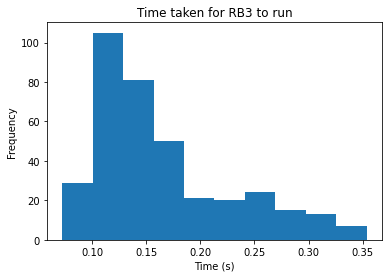

In [88]:
# Sample list of values
values = RB3_TIMES

# Plotting the histogram
plt.hist(values, bins=10)
# Adding labels and title
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Time taken for RB3 to run')

plt.show()



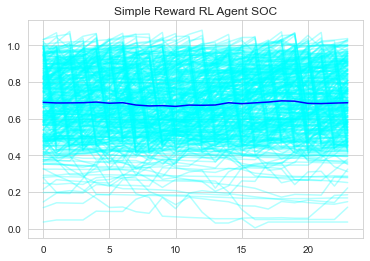

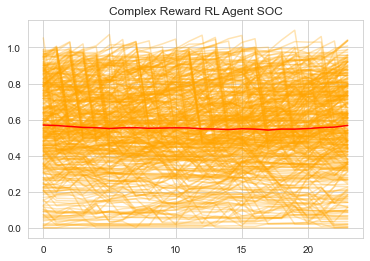

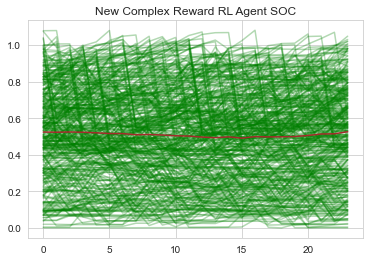

In [126]:
# Plot the average SOC for Simple and Complex RL Agents
simple_vals = []
for i in range(24):
    b = 0
    for line in SIMPLE_SOC:
        b += line[i]
    simple_vals.append(b/len(SIMPLE_SOC))

# plt.plot(x_values, simple_vals, label='Simple Reward RL Agent')

complex_vals = []
for i in range(24):
    b = 0
    for line in COMPLEX_SOC:
        b += line[i]
    complex_vals.append(b/len(COMPLEX_SOC))

new_vals = []
for i in range(24):
    b = 0
    for line in NEW_SOC:
        b += line[i]
    new_vals.append(b/len(NEW_SOC))


x_values = list(range(len(SIMPLE_SOC[0])))

for line in SIMPLE_SOC:
    plt.plot(x_values, line, 'cyan', alpha=0.3)
plt.plot(x_values, simple_vals, 'blue', label='Simple Reward RL Agent')
plt.title('Simple Reward RL Agent SOC')
plt.show()

x_values = list(range(len(COMPLEX_SOC[0])))

for line in COMPLEX_SOC:
    plt.plot(x_values, line, color='orange', alpha=0.3)
plt.plot(x_values, complex_vals, label='Complex Reward RL Agent', color='red')
plt.title('Complex Reward RL Agent SOC')
plt.show()

x_values = list(range(len(NEW_SOC[0])))

for line in NEW_SOC:
    plt.plot(x_values, line, color='green', alpha=0.3)
plt.plot(x_values, new_vals, label='New Complex Reward RL Agent', color='brown')
plt.title('New Complex Reward RL Agent SOC')
plt.show()


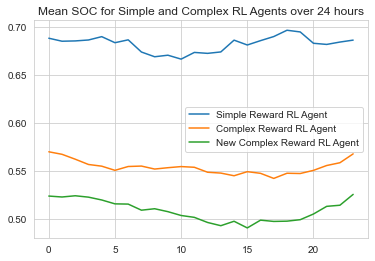

In [127]:
# Plot the average SOC for Simple and Complex RL Agents
plt.plot(x_values, simple_vals, label='Simple Reward RL Agent')
plt.plot(x_values, complex_vals, label='Complex Reward RL Agent')
plt.plot(x_values, new_vals, label='New Complex Reward RL Agent')
plt.title('Mean SOC for Simple and Complex RL Agents over 24 hours')
plt.legend()
plt.show()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


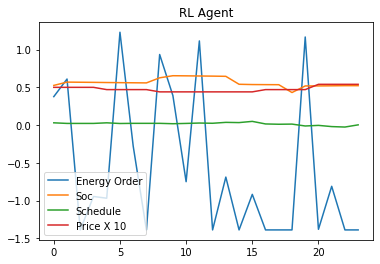

Bank: -0.03614400000000002


In [94]:
m = BestMarket(0, grid_fee_matrix=[[0]])
m.energy_unit = 0.001

# Simple Reward RL Agent
max_obv=1.4 
horizon=24
aggregated=False

model_number = 1800000
algorithm = '24/1.4/complex+random2_03-14-10-05'


env = MyEnv(horizon=horizon, initial_soc=0.5, actor_df=actor_df, aggregated=aggregated, max_obv=max_obv)
models_dir = f"models/{algorithm}"
model_path = f"{models_dir}/{model_number}"
model = PPO.load(model_path, env=env)

observation = env.reset()
socs = []
orders = []

for i in range(24):
    action, _ = model.predict(observation)
    observation, reward, done, _ = env.step(action)
    
    if done:
        print(f'{algorithm} agent failed')
        break
    socs.append(env.actor.battery.soc)
    if _['order']:
        if _['order'].type == -1:
            orders.append(_['order'].energy)
        elif _['order'].type == 1:
            orders.append(-_['order'].energy)
if not done:
    battery_energy = env.actor.battery.energy()
    mean_price = env.actor.pred['prices'].mean()
    bank_with_battery = evaluate_battery_soc(battery_energy, mean_price, battery_discount=0.7) + env.actor.bank

plt.plot(orders, label='Energy Order')
plt.plot(socs, label='Soc')
plt.plot(list(actor_df.iloc[:24, 3]), label='Schedule')
plt.plot(list(actor_df.iloc[:24, 2]*10), label='Price X 10')
plt.title('RL Agent')
plt.savefig('rl-plot.png')
plt.legend()
plt.show()
print('Bank:', env.actor.bank)


Order(type=-1, time=0, actor_id='S2', cluster=None, energy=12.580862810948581, price=0.082)
Order(type=1, time=1, actor_id='S2', cluster=None, energy=10.23, price=0.0747)
Order(type=1, time=2, actor_id='S2', cluster=None, energy=0.018999999999996575, price=0.0783)
Order(type=-1, time=3, actor_id='S2', cluster=None, energy=0.038000000000000145, price=0.102)
Order(type=1, time=4, actor_id='S2', cluster=None, energy=13.181000000000001, price=0.1008)
Order(type=1, time=5, actor_id='S2', cluster=None, energy=3.5700000000000003, price=0.1098)
None
None
None
None
None
Order(type=-1, time=11, actor_id='S2', cluster=None, energy=10.832, price=0.082)
Order(type=1, time=12, actor_id='S2', cluster=None, energy=1.366999999999999, price=0.0747)
Order(type=-1, time=13, actor_id='S2', cluster=None, energy=0.3920000000000006, price=0.083)
Order(type=1, time=14, actor_id='S2', cluster=None, energy=12.544, price=0.08460000000000001)
None
Order(type=1, time=16, actor_id='S2', cluster=None, energy=10.12799

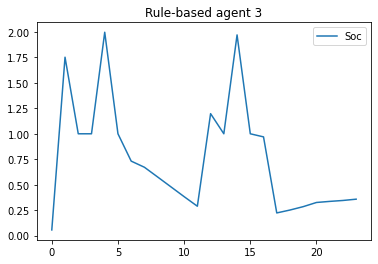

[0.05593608807788286,
 1.752074074074074,
 0.9999999999999998,
 1.0,
 1.9971851851851852,
 0.9999999999999999,
 0.7315555555555555,
 0.6712592592592592,
 0.5755555555555555,
 0.4791851851851851,
 0.3826666666666666,
 0.2885925925925925,
 1.1976296296296296,
 1.0,
 1.970962962962963,
 1.0,
 0.9695555555555555,
 0.2227407407407408,
 0.25125925925925924,
 0.2844444444444444,
 0.32540740740740737,
 0.33599999999999997,
 0.3451111111111111,
 0.3578518518518518]

In [ ]:
actor_df = pd.read_csv('/Users/emilmargrain/Documents/GitHub/simply/example_actor_df.csv')
actor_df[:24]

# Rule-based agent 3
m_2 = BestMarket(0, grid_fee_matrix=[[0]])
m_2.energy_unit = 0.001
battery = Battery(soc_initial=initial_soc)
actor = Actor('S2', actor_df, battery=battery, horizon=24, ps=1)

soc_list2 = []
orders2 = []

# Iterate through timesteps
for t in range(24):
    m_2.t = t
    actor.generate_market_schedule(strategy=3)
    soc_list2.append(actor.battery.soc)
    order = actor.generate_order()
    print(order)
    if order:
        if order.type == -1:
            orders2.append(order.energy)
        elif order.type == 1:
            orders2.append(-order.energy)    
    else:
        orders2.append(0)
    if order:
        # Generate market maker order
        m_2.accept_order(order)
    # Generate market maker order
    m_2.accept_order(Order(1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                actor.data.iloc[t, 2]))
    m_2.accept_order(Order(-1, t, 'market_maker', None, MARKET_MAKER_THRESHOLD,
                                actor.data.iloc[t, 2]))
    m_2.clear()
    update_bank(m_2.matches, actor)



# plt.plot(orders2, label='Energy Order')
plt.plot(soc_list2, label='Soc')
# plt.plot(list(actor_df.iloc[:24, 4]), label='Schedule')
# plt.plot(list(actor_df.iloc[:24, 3]*10), label='Price X 10')
print('RB3:', actor.bank)
plt.legend() 
plt.title('Rule-based agent 3')
plt.savefig('rb2-plot.png')
plt.show()

soc_list2

RB2: 0


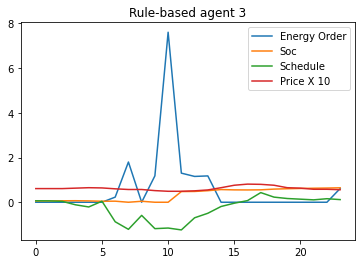

[0.05593608807788286, 0.060750902892697675, 0.06534349548529027, 0.06830645844825323, 0.059862014003808785, 0.04423238437417916, 0.04763979178158657, 0.0, 0.04348148148148148, 0.0, 0.0, 0.47748148148148145, 0.4822222222222222, 0.5162222222222222, 0.566888888888889, 0.5528148148148149, 0.5496296296296297, 0.5550370370370371, 0.586962962962963, 0.603925925925926, 0.6162962962962963, 0.6264444444444445, 0.6343703703703704, 0.646074074074074]


In [ ]:
plt.plot(orders2, label='Energy Order')
plt.plot(soc_list2, label='Soc')
plt.plot(list(actor_df.iloc[:24, 3]), label='Schedule')
plt.plot(list(actor_df.iloc[:24, 2]*10), label='Price X 10')
print('RB2:', actor.bank)
plt.legend() 
plt.title('Rule-based agent 3')
plt.savefig('rb2-plot.png')
plt.show()

print(soc_list2)

## Comparing Reward Functions Statistically

### Confidence Intervals:

Confidence intervals can be used to estimate the range of values within which the true difference between the two techniques is likely to lie. 


In [ ]:
look_up = {0: 'Simple RL', 1: 'Complex RL', 2: 'New Complex RL', 3: 'RB2', 4: 'RB3'}

# Combine the data into a single array
data = np.array([FAST_SIMPLE_BANKS, FAST_COMPLEX_BANKS, NEW_COMPLEX_BANKS, RB2_BANKS, RB3_BANKS])

# Calculate the mean and standard deviation for each technique
means = np.mean(data, axis=1)
stds = np.std(data, axis=1, ddof=1)  # set degrees of freedom to n-1

# Calculate the 95% confidence interval for the mean of each technique
alpha = 0.05
n = data.shape[1]
t_value = t.ppf(1 - alpha/2, n-1)
lower_bounds = means - t_value * stds / np.sqrt(n)
upper_bounds = means + t_value * stds / np.sqrt(n)

print('Banks:')
print()
# Print the results
for i in range(len(means)):
    print(f"{look_up[i]}: Mean={means[i]:.2f}, 95% Confidence Interval=({lower_bounds[i]:.2f}, {upper_bounds[i]:.2f})")

# Combine the data into a single array
data = np.array([FAST_SIMPLE_BANK_AND_BATTERY, FAST_COMPLEX_BANK_AND_BATTERY, NEW_COMPLEX_BANK_AND_BATTERY, RB2_BANK_AND_BATTERY, RB3_BANK_AND_BATTERY])

# Calculate the mean and standard deviation for each technique
means = np.mean(data, axis=1)
stds = np.std(data, axis=1, ddof=1)  # set degrees of freedom to n-1

# Calculate the 95% confidence interval for the mean of each technique
alpha = 0.05
n = data.shape[1]
t_value = t.ppf(1 - alpha/2, n-1)
lower_bounds = means - t_value * stds / np.sqrt(n)
upper_bounds = means + t_value * stds / np.sqrt(n)

print()
print('Banks and Batteries:')
print()
# Print the results
for i in range(len(means)):
    print(f"{look_up[i]}: Mean={means[i]:.2f}, 95% Confidence Interval=({lower_bounds[i]:.2f}, {upper_bounds[i]:.2f})")

Banks:

Simple RL: Mean=0.11, 95% Confidence Interval=(0.09, 0.14)
Complex RL: Mean=0.11, 95% Confidence Interval=(0.09, 0.13)
New Complex RL: Mean=0.12, 95% Confidence Interval=(0.10, 0.14)
RB2: Mean=-0.09, 95% Confidence Interval=(-0.10, -0.08)
RB3: Mean=0.03, 95% Confidence Interval=(-0.03, 0.10)

Banks and Batteries:

Simple RL: Mean=0.44, 95% Confidence Interval=(0.41, 0.47)
Complex RL: Mean=0.38, 95% Confidence Interval=(0.35, 0.40)
New Complex RL: Mean=0.36, 95% Confidence Interval=(0.33, 0.39)
RB2: Mean=-0.01, 95% Confidence Interval=(-0.02, 0.01)
RB3: Mean=0.27, 95% Confidence Interval=(0.23, 0.32)


### Hypothesis Testing:

Since we are comparing 5 different techniques, we can use the ANOVA (Analysis of Variance) test. ANOVA is used to test whether there are significant differences between the means of multiple groups.

The first test checks whether there is a statistically significant difference between the techniques

In [141]:
# Perform one-way ANOVA test
f_value, p_value = f_oneway(FAST_SIMPLE_BANKS, FAST_COMPLEX_BANKS, NEW_COMPLEX_BANKS)

print('When comparing the three RL techniques (banks) with a Analysis of Variance test:')
alpha = 0.05 # Set the level of significance
if p_value < alpha:
    print("Significant difference between techniques: YES")
else:
    print("Significant difference between the techniques: NO")


f_value, p_value = f_oneway(FAST_SIMPLE_BANK_AND_BATTERY, FAST_COMPLEX_BANK_AND_BATTERY, NEW_COMPLEX_BANK_AND_BATTERY)
print()
print('When comparing the three RL techniques (banks and batterys) with a Analysis of Variance test:')
alpha = 0.05 # Set the level of significance
if p_value < alpha:
    print("Significant difference between techniques: YES")
else:
    print("Significant difference between the techniques: NO")


f_value, p_value = f_oneway(RB2_BANKS, RB3_BANKS)
print()
print('When comparing the two Rule-based (banks) techniques with a Analysis of Variance test:')
alpha = 0.05 # Set the level of significance
if p_value < alpha:
    print("Significant difference between techniques: YES")
else:
    print("Significant difference between the techniques: NO")

f_value, p_value = f_oneway(RB2_BANK_AND_BATTERY, RB3_BANK_AND_BATTERY)
print()
print('When comparing the two Rule-based (banks and batterys) techniques with a Analysis of Variance test:')
alpha = 0.05 # Set the level of significance
if p_value < alpha:
    print("Significant difference between techniques: YES")
else:
    print("Significant difference between the techniques: NO")

When comparing the three RL techniques (banks) with a Analysis of Variance test:
Significant difference between the techniques: NO

When comparing the three RL techniques (banks and batterys) with a Analysis of Variance test:
Significant difference between techniques: YES

When comparing the two Rule-based (banks) techniques with a Analysis of Variance test:
Significant difference between techniques: YES

When comparing the two Rule-based (banks and batterys) techniques with a Analysis of Variance test:
Significant difference between techniques: YES


### Effect Size:

Effect size measures such as Cohen's d, Hedges' g, or Pearson's r can be used to quantify the size of the difference between the two techniques. A larger effect size suggests a more significant difference between the techniques.

Here I will use Cohen's d to measure the effect size:

In [158]:
# Combine the data into a single array
data = np.array([FAST_SIMPLE_BANKS, FAST_COMPLEX_BANKS, NEW_COMPLEX_BANKS, RB2_BANKS, RB3_BANKS])

# Calculate Cohen's d for each pair of techniques
effect_sizes = []
for i in range(data.shape[0]):
    for j in range(i+1, data.shape[0]):
        t_stat, p_value = ttest_ind(data[i], data[j])
        cohens_d = (np.mean(data[i]) - np.mean(data[j])) / np.sqrt((np.std(data[i])**2 + np.std(data[j])**2) / 2)
        effect_sizes.append((f"{look_up[i]} vs {look_up[j]}", cohens_d))

print('An effect size of 0.2 is considered a small effect, 0.5 a medium effect, and 0.8 a large effect.')
print()
# Print the effect sizes
for es in effect_sizes:
    print(f"{es[0]}: Cohen's d={es[1]:.2f}")


An effect size of 0.2 is considered a small effect, 0.5 a medium effect, and 0.8 a large effect.

Simple RL vs Complex RL: Cohen's d=0.01
Simple RL vs New Complex RL: Cohen's d=-0.02
Simple RL vs RB2: Cohen's d=1.04
Simple RL vs RB3: Cohen's d=0.17
Complex RL vs New Complex RL: Cohen's d=-0.03
Complex RL vs RB2: Cohen's d=1.26
Complex RL vs RB3: Cohen's d=0.17
New Complex RL vs RB2: Cohen's d=1.19
New Complex RL vs RB3: Cohen's d=0.18
RB2 vs RB3: Cohen's d=-0.29


## Evaluate Trading Performance

### Daily Profit:

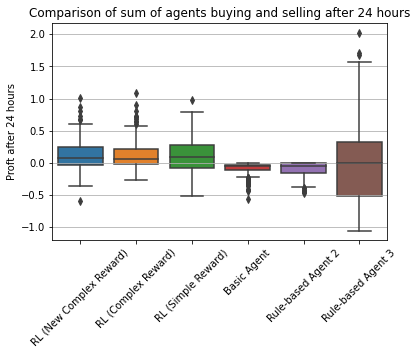

New Complex Reward Mean: 0.11858237808219177
Complex Reward Mean: 0.11238492054794519
Simple Reward Mean: 0.11367650958904109
Basic Agent Mean: -0.0842412109589041
Rule-based Agent 2 Mean: -0.09319948767123289
Rule-based Agent 3 Mean: 0.034705202739726014
t-value: -0.07500291028974955
p-value: 0.9402330010515525


In [95]:
# Combine the data into a list
box_df = pd.DataFrame({ 'RL (New Complex Reward)': NEW_COMPLEX_BANKS,
                        'RL (Complex Reward)': FAST_COMPLEX_BANKS,
                        'RL (Simple Reward)': FAST_SIMPLE_BANKS,
                        'Basic Agent': BASIC_BANKS,
                        'Rule-based Agent 2': RB2_BANKS,
                        'Rule-based Agent 3': RB3_BANKS})

# Create a figure and axis object
fig, ax = plt.subplots()

# # Create the boxplot
sns.boxplot(data=box_df, ax=ax)

# Label the x-axis
ax.set_ylabel('Proft after 24 hours')

# Rotate the xticklabels by 45 degrees
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(xtick_labels, rotation=45)

# Add grid lines
ax.yaxis.grid(True)

# Show the plot
plt.title('Comparison of sum of agents buying and selling after 24 hours')
plt.show()

print('New Complex Reward Mean:', np.mean(NEW_COMPLEX_BANKS))
print('Complex Reward Mean:', np.mean(FAST_COMPLEX_BANKS))
print('Simple Reward Mean:', np.mean(FAST_SIMPLE_BANKS))
print('Basic Agent Mean:', np.mean(BASIC_BANKS))
print('Rule-based Agent 2 Mean:', np.mean(RB2_BANKS))
print('Rule-based Agent 3 Mean:', np.mean(RB3_BANKS))

t, p = ttest_ind(FAST_COMPLEX_BANKS, FAST_SIMPLE_BANKS, equal_var=True)
print("t-value:", t)
print("p-value:", p)


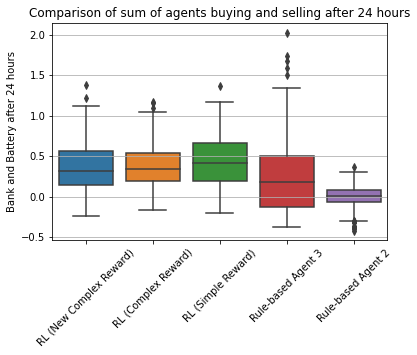

New Complex Reward Mean: 0.3619851353424639
Complex Reward Mean: 0.37603832684931227
Simple Reward Mean: 0.43640710310501524
Rule-based Agent 3 Mean: 0.2739993071232877
Rule-based Agent 2 Mean: -0.006944998630136987
t-value: -2.9503272645595575
p-value: 0.0032762382753758145


In [96]:
# Combine the data into a list

box_df = pd.DataFrame({ 'RL (New Complex Reward)': NEW_COMPLEX_BANK_AND_BATTERY,
                        'RL (Complex Reward)': FAST_COMPLEX_BANK_AND_BATTERY,
                        'RL (Simple Reward)': FAST_SIMPLE_BANK_AND_BATTERY,
                        'Rule-based Agent 3': RB3_BANK_AND_BATTERY,
                        'Rule-based Agent 2': RB2_BANK_AND_BATTERY
                        })

# Create a figure and axis object
fig, ax = plt.subplots()

# # Create the boxplot
sns.boxplot(data=box_df, ax=ax)

# Label the x-axis
ax.set_ylabel('Bank and Battery after 24 hours')

# Rotate the xticklabels by 45 degrees
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(xtick_labels, rotation=45)

# Add grid lines
ax.yaxis.grid(True)

# Show the plot
plt.title('Comparison of sum of agents buying and selling after 24 hours')
plt.show()

print('New Complex Reward Mean:', np.mean(NEW_COMPLEX_BANK_AND_BATTERY))
print('Complex Reward Mean:', np.mean(FAST_COMPLEX_BANK_AND_BATTERY))
print('Simple Reward Mean:', np.mean(FAST_SIMPLE_BANK_AND_BATTERY))
print('Rule-based Agent 3 Mean:', np.mean(RB3_BANK_AND_BATTERY))
print('Rule-based Agent 2 Mean:', np.mean(RB2_BANK_AND_BATTERY))

t, p = ttest_ind(FAST_COMPLEX_BANK_AND_BATTERY, FAST_SIMPLE_BANK_AND_BATTERY, equal_var=True)
print("t-value:", t)
print("p-value:", p)


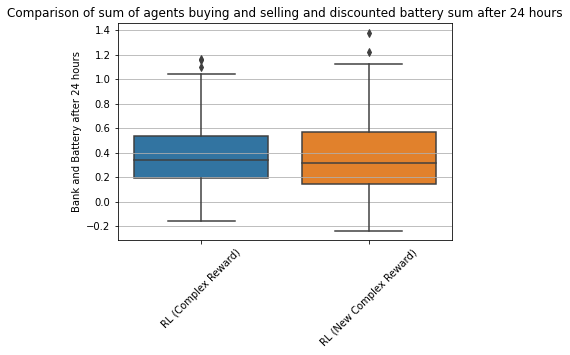

Complex Bank and Battery Mean: 0.37603832684931227
RL (New Complex Reward): 0.3619851353424639
RL (Simple Reward): 0.43640710310501524
t-value: 0.7202172030000898
p-value: 0.4716224455478799


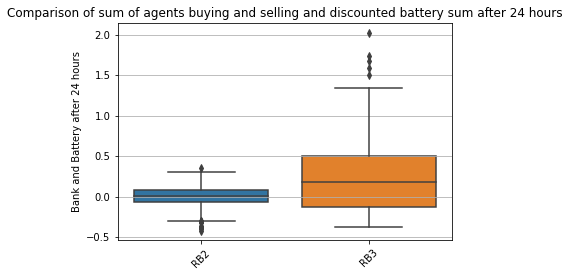

RB2: -0.006944998630136987
RB3: 0.2739993071232877
t-value: -11.015660812865537
p-value: 3.303659414024879e-26


In [97]:
# Comparing both versions of the complex reward
box_df = pd.DataFrame({ 'RL (Complex Reward)': FAST_COMPLEX_BANK_AND_BATTERY,
                        'RL (New Complex Reward)': NEW_COMPLEX_BANK_AND_BATTERY})

# Create a figure and axis object
fig, ax = plt.subplots()

# # Create the boxplot
sns.boxplot(data=box_df, ax=ax)

# Label the x-axis
ax.set_ylabel('Bank and Battery after 24 hours')

# Rotate the xticklabels by 45 degrees
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(xtick_labels, rotation=45)

# Add grid lines
ax.yaxis.grid(True)

# Show the plot
plt.title('Comparison of sum of agents buying and selling and discounted battery sum after 24 hours')
plt.show()

print('Complex Bank and Battery Mean:', np.mean(FAST_COMPLEX_BANK_AND_BATTERY))
print('RL (New Complex Reward):', np.mean(NEW_COMPLEX_BANK_AND_BATTERY))
print('RL (Simple Reward):', np.mean(FAST_SIMPLE_BANK_AND_BATTERY))

t, p = ttest_ind(FAST_COMPLEX_BANK_AND_BATTERY, NEW_COMPLEX_BANK_AND_BATTERY, equal_var=True)
print("t-value:", t)
print("p-value:", p)

# Comparing both versions of the Rule-based agent

box_df = pd.DataFrame({ 'RB2': RB2_BANK_AND_BATTERY,
                        'RB3': RB3_BANK_AND_BATTERY})

# Create a figure and axis object
fig, ax = plt.subplots()

# # Create the boxplot
sns.boxplot(data=box_df, ax=ax)

# Label the x-axis
ax.set_ylabel('Bank and Battery after 24 hours')

# Rotate the xticklabels by 45 degrees
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(xtick_labels, rotation=45)

# Add grid lines
ax.yaxis.grid(True)

# Show the plot
plt.title('Comparison of sum of agents buying and selling and discounted battery sum after 24 hours')
plt.show()

print('RB2:', np.mean(RB2_BANK_AND_BATTERY))
print('RB3:', np.mean(RB3_BANK_AND_BATTERY))


t, p = ttest_ind(RB2_BANK_AND_BATTERY, RB3_BANK_AND_BATTERY, equal_var=True)
print("t-value:", t)
print("p-value:", p)



### Cumulative Profit:

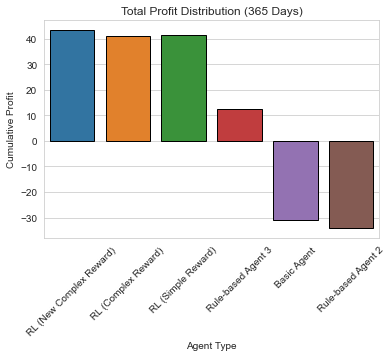

In [116]:
# Define the data
labels = ['RL (New Complex Reward)', 'RL (Complex Reward)', 'RL (Simple Reward)', 'Rule-based Agent 3', 'Basic Agent', 'Rule-based Agent 2']
values = [sum(NEW_COMPLEX_BANKS), sum(FAST_COMPLEX_BANKS), sum(FAST_SIMPLE_BANKS), sum(RB3_BANKS), sum(BASIC_BANKS),  sum(RB2_BANKS)]

# Create a figure and axis object
fig, ax = plt.subplots()

# Create the bar chart using Seaborn
# sns.set_style('whitegrid')
sns.barplot(x=labels, y=values, ax=ax, edgecolor='black')

# Rotate the xticklabels by 45 degrees
xtick_labels = ax.get_xticklabels()
ax.set_xticklabels(xtick_labels, rotation=45)

# Add grid lines
ax.yaxis.grid(True)

# Set the title and axis labels
plt.title('Total Profit Distribution (365 Days)')
plt.xlabel('Agent Type')
plt.ylabel('Cumulative Profit')

# Show the plot
plt.show()

In [122]:
import plotly.graph_objs as go

# Create the time axis
dates = pd.date_range(start='2016-01-01', end='2016-12-31', freq='D')

# Create traces for each bank type
trace1 = go.Scatter(x=dates, y=NEW_COMPLEX_BANKS, name='New Complex RL Agent')
trace2 = go.Scatter(x=dates, y=FAST_SIMPLE_BANKS, name='Fast Simple RL Agent')
trace3 = go.Scatter(x=dates, y=FAST_COMPLEX_BANKS, name='Fast Complex RL Agent')
trace4 = go.Scatter(x=dates, y=BASIC_BANKS, name='Basic Agent')
trace5 = go.Scatter(x=dates, y=RB3_BANKS, name='RB3 Agent')
trace6 = go.Scatter(x=dates, y=RB2_BANKS, name='RB2 Agent')

# Create the figure layout
layout = go.Layout(title='Profit Trends over 365 days (2016)', xaxis={'title': 'Date'},
                   yaxis={'title': 'Daily Profit'}, height=500, hovermode='closest',
                   xaxis_rangeslider_visible=True)

# Create the figure and add the traces
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6], layout=layout)

# Display the figure
fig.show()


### Sharpe Ratio:

### Average Trade Size:

## Creating Complex Networks

In [34]:
nw = nx.Graph()
nw.add_edges_from([(0, 1, {"weight": 1}), (1, 2), (1, 3), (0, 4)])
pn = PowerNetwork("", nw, weight_factor=1)

m = BestMarket(0, pn)



## Training the agent in network with other RL Agents